In [90]:
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
import re
import glob
import numpy as np

In [91]:
def load_gemm_data(path: str):
    files = glob.glob(path + "/*.jsonl")
    pattern = re.compile(r"M(\d+)_N(\d+)_K(\d+)")
    
    dfs = []
    for file in files:
        match = pattern.search(file)
        if match:
            M, N, K = match.groups()
            df = pl.read_ndjson(file).filter(pl.col("is_best") == "true")
            dfs.append(df)
    
    if dfs:
        combined_df = pl.concat(dfs)
    else:
        raise RuntimeError("No data loaded")
    return combined_df

In [92]:
def calculate_metrics(df):
    df = df.with_columns([
        (pl.col("tflops") / pl.col("gb_per_sec")).alias("operational_intensity"),
        (pl.col("M").cast(pl.Utf8) + "_" + pl.col("N").cast(pl.Utf8) + "_" + pl.col("K").cast(pl.Utf8)).alias("group")
    ])
    return df

In [93]:
def define_roofline(peak_compute, peak_bandwidth):
    oi = np.logspace(-2, 3, 500)
    roofline_perf = np.minimum(peak_compute, peak_bandwidth * oi)
    
    roofline_df = pl.DataFrame({
        "operational_intensity": oi,
        "performance": roofline_perf
    })

    return roofline_df


In [94]:
def generate_roofline_plot(combined_df, roofline_df):
    oi = pl.Series(np.logspace(-3.2, -0.5, 500))
    roofline_perf = pl.Series(np.minimum(peak_compute, peak_bandwidth * oi))
    roofline_df = pl.DataFrame({"operational_intensity": oi, "performance": roofline_perf})
    
    # Apply square root scaling to 'time_ms'
    combined_df = combined_df.with_columns(
        (pl.col("time_ms").sqrt().alias("time_scaled"))
    )
    
    # Create main scatter plot 
    fig = px.scatter(
        combined_df, 
        x="operational_intensity",
        y="tflops",
        color="M",
        size="time_scaled",
        hover_data=["time_ms","operation", "M", "N", "K"],
        labels={
            "operational_intensity": "Operational Intensity (TFLOPs/GB/s)",
            "tflops": "Performance (TFLOPs)",
            "time_ms": "Execution Time (ms)"
        },
        title="AMD RX 7900 XTX Roofline Analysis"
    )
    
    # Add roofline
    fig.add_trace(go.Scatter(
        x=roofline_df["operational_intensity"].to_list(),
        y=roofline_df["performance"].to_list(),
        mode='lines',
        line=dict(color='tomato', width=1),
        opacity=0.45,
        name='Theoretical Roofline'
    ))
    
    # Configure axes
    fig.update_layout(
        xaxis_type="log",
        yaxis_type="log",
        legend=dict(orientation="h", yanchor="bottom", y=1.02)
    )
    
    return fig


# Define Roofline for RX 7900 XTX GPU

Spec from https://en.wikipedia.org/wiki/List_of_AMD_graphics_processing_units

Processing power for RX 7900 XTX in TFLPOS

|Half|Single|Double|
|---|---|---|
|61.44|61.44|0.960|

Memory bandwidth in GB/s

960

In [103]:
roofline = define_roofline(61.44, 960)

# Simple GEMM sweep

This sweep is defined as 

> - Datatype `bf16`
> - For `M,N,K` use `N=K` for powers of 2 from 64 to 16384
> - `M=1,2,4,...,256`
> - Select the best results

In [97]:
bf16_df = load_gemm_data("gemm_scan_results_bf16")
bf16_df = calculate_metrics(bf16_df)
fig = generate_roofline_plot(bf16_df, roofline)

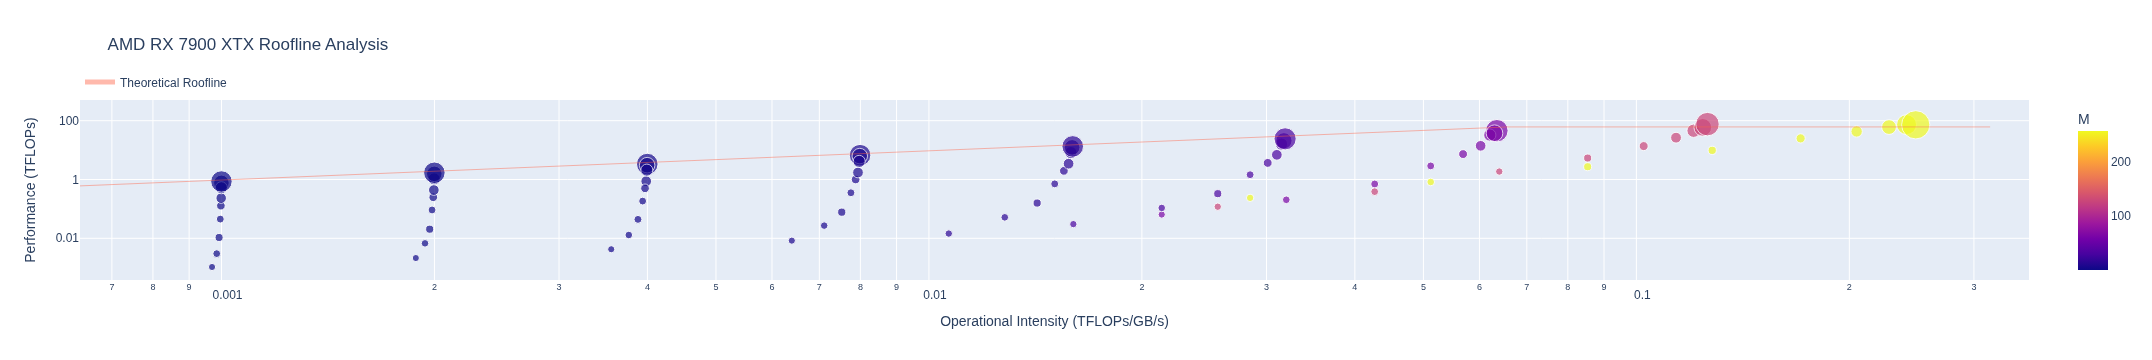

In [98]:
fig.show()

# Simple GEMM sweep fp32

This sweep is defined as 

> - Datatype `fp32`
> - For `M,N,K` use `N=K` for powers of 2 from 64 to 16384
> - `M=1,2,4,...,256`
> - Select the best results


Some of the profile jobs did not produce any data. Hence only 6 series in the plot

In [99]:
fp32_df = load_gemm_data("gemm_scan_results_fp32")
fp32_df = calculate_metrics(fp32_df)
fig = generate_roofline_plot(fp32_df, roofline)

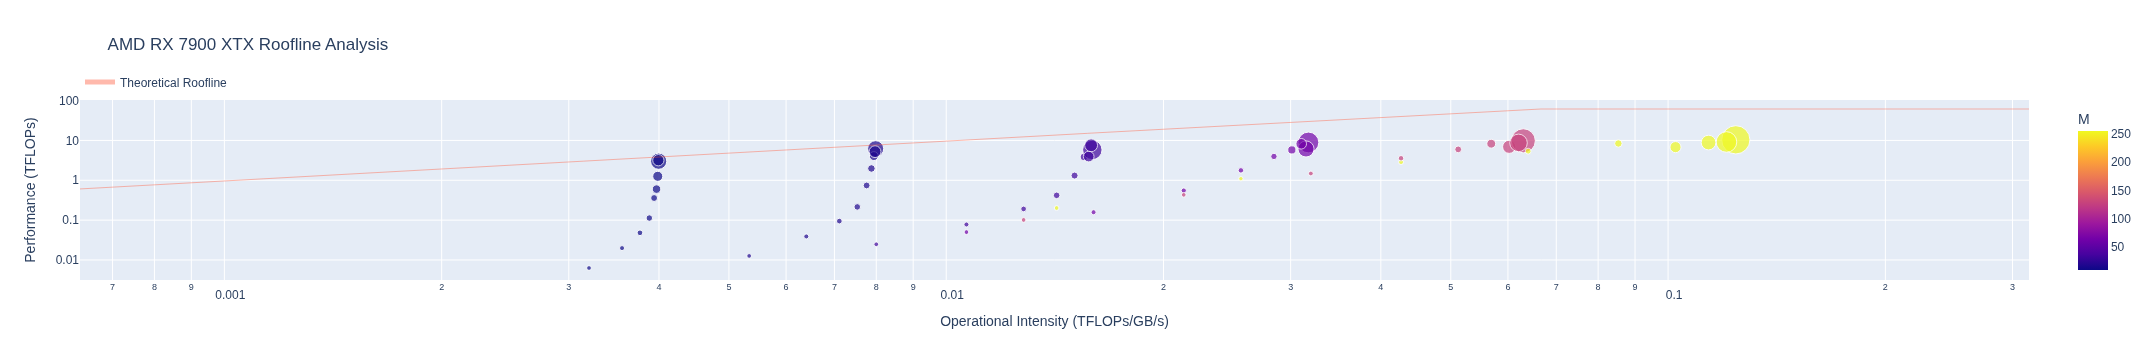

In [100]:
fig.show()

# Simple GEMM sweep fp16

This sweep is defined as 

> - Datatype `fp16`
> - For `M,N,K` use `N=K` for powers of 2 from 64 to 16384
> - `M=1,2,4,...,256`
> - Select the best results


In [101]:
fp16_df = load_gemm_data("gemm_scan_results_fp16")
fp16_df = calculate_metrics(fp16_df)
fig = generate_roofline_plot(fp16_df, roofline)

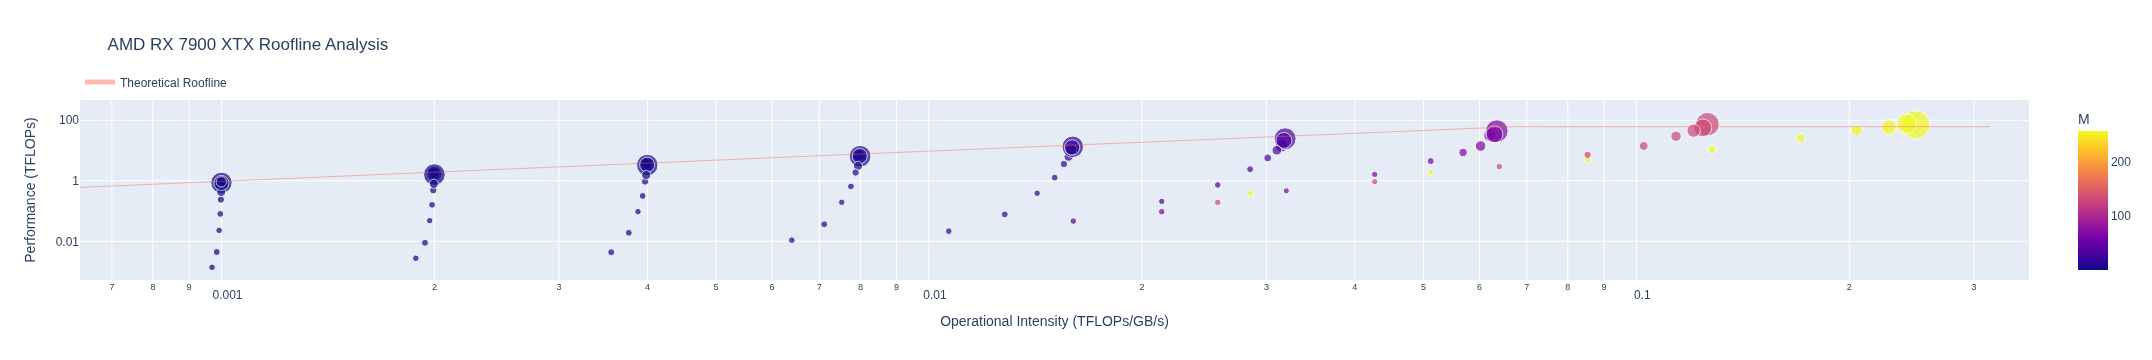

In [102]:
fig.show()

# Simple GEMM sweep int8

This sweep is defined as 

> - Datatype `int8`
> - For `M,N,K` use `N=K` for powers of 2 from 64 to 16384
> - `M=1,2,4,...,256`
> - Select the best results


In [104]:
int8_df = load_gemm_data("gemm_scan_results_int8")
int8_df = calculate_metrics(int8_df)
fig = generate_roofline_plot(int8_df, roofline)

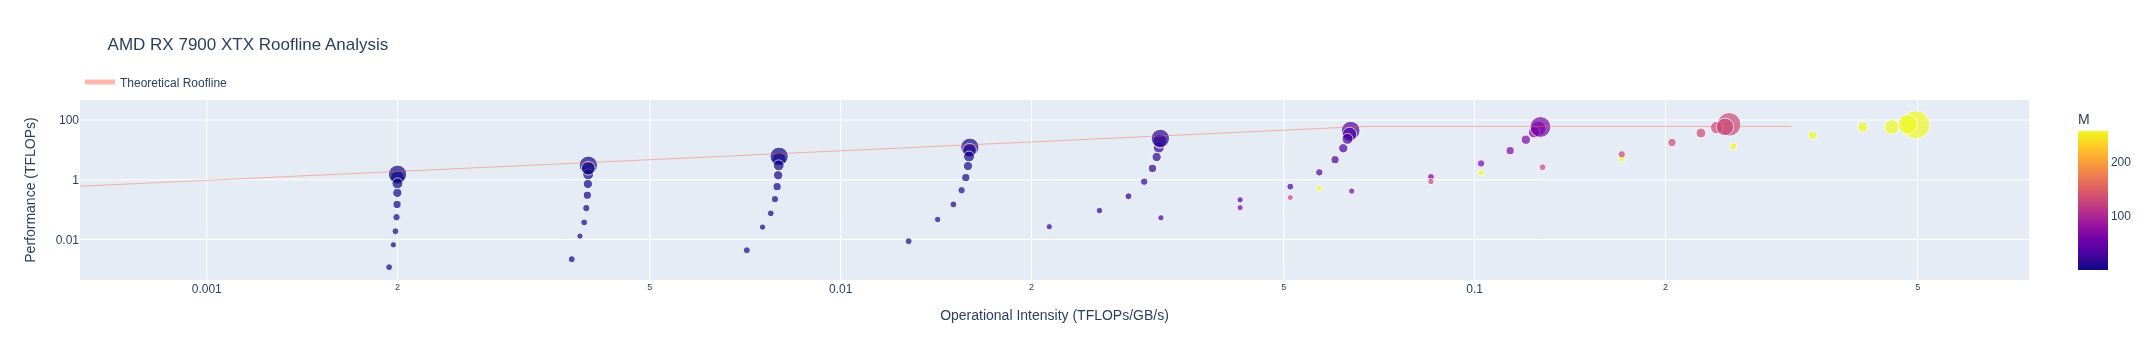

In [106]:
fig.show()